In [1]:
import requests
from openai import OpenAI
from dotenv import load_dotenv
import os
load_dotenv()

openai_client = OpenAI()
gemini = OpenAI(
    api_key=os.getenv("GEMINI_API_KEY"),
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)
deepseek = OpenAI(
    api_key=os.getenv("DEEPSEEK_API_KEY"),
    base_url="https://api.deepseek.com"
)
import matplotlib.pyplot as plt
import json

GROUP_THEM_URL = "http://127.0.0.1:8080/groupthem"

In [2]:
state = requests.get(GROUP_THEM_URL).json()
state

{'guesses': [],
 'available_words': [{'text': 'hub',
   'group': {'name': 'Unknown', 'ranking': 'VeryDifficult'}},
  {'text': 'strap', 'group': {'name': 'Unknown', 'ranking': 'Hard'}},
  {'text': 'night', 'group': {'name': 'Unknown', 'ranking': 'VeryDifficult'}},
  {'text': 'bud', 'group': {'name': 'Unknown', 'ranking': 'Medium'}},
  {'text': 'knee', 'group': {'name': 'Unknown', 'ranking': 'VeryDifficult'}},
  {'text': 'bub', 'group': {'name': 'Unknown', 'ranking': 'Medium'}},
  {'text': 'man', 'group': {'name': 'Unknown', 'ranking': 'Medium'}},
  {'text': 'wrench', 'group': {'name': 'Unknown', 'ranking': 'Easy'}},
  {'text': 'yank', 'group': {'name': 'Unknown', 'ranking': 'Easy'}},
  {'text': 'bolster', 'group': {'name': 'Unknown', 'ranking': 'Hard'}},
  {'text': 'mad', 'group': {'name': 'Unknown', 'ranking': 'VeryDifficult'}},
  {'text': 'jerk', 'group': {'name': 'Unknown', 'ranking': 'Easy'}},
  {'text': 'tug', 'group': {'name': 'Unknown', 'ranking': 'Easy'}},
  {'text': 'block', 'g

In [3]:
words = [x["text"] for x in state["available_words"]]
", ".join(words)

'hub, strap, night, bud, knee, bub, man, wrench, yank, bolster, mad, jerk, tug, block, mat, jack'

### WordGuess

In [4]:
todo

NameError: name 'todo' is not defined

### GroupThem

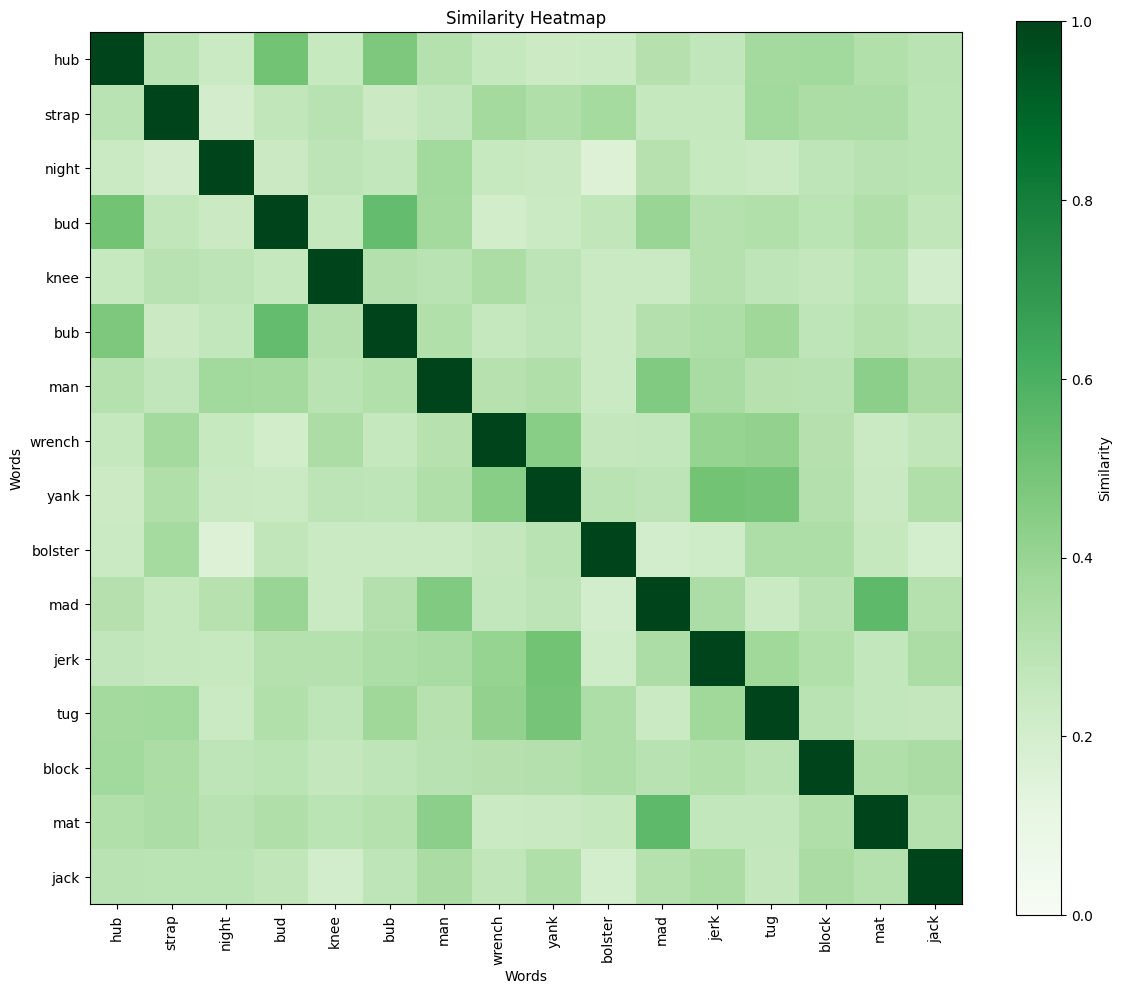

### Group: ['mad', 'mat', 'man', 'bud']
 Majority ranking: 'Medium' with 2/4 words (50.0% accuracy)
### Group: ['bub', 'hub', 'tug', 'jerk']
 Majority ranking: 'Easy' with 2/4 words (50.0% accuracy)
### Group: ['yank', 'wrench', 'jack', 'strap']
 Majority ranking: 'Easy' with 2/4 words (50.0% accuracy)
### Group: ['block', 'bolster', 'night', 'knee']
 Majority ranking: 'Hard' with 2/4 words (50.0% accuracy)

### Overall accuracy: 50.0%


In [4]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Fetch the game state from the URL
state = requests.get(GROUP_THEM_URL).json()

# Create a mapping from word to its ranking score (from the game state)
word_to_ranking = {item["text"]: item["group"]["ranking"] for item in state["available_words"]}

# List of words available in the game
words = list(word_to_ranking.keys())

# Get embeddings for all words (assumes openai_client is already defined/initialized)
embeddings_response = openai_client.embeddings.create(
    model="text-embedding-3-large",
    input=words
)
embeddings = [item.embedding for item in embeddings_response.data]

amount = len(embeddings)

# Compute the similarity matrix using dot product
similarity_matrix = np.zeros((amount, amount))
for i in range(amount):
    for j in range(amount):
        if i != j:
            similarity_matrix[i, j] = np.dot(embeddings[i], embeddings[j])
        else:
            similarity_matrix[i, j] = 1

# Plot the similarity matrix
plt.figure(figsize=(12, 10))
plt.imshow(similarity_matrix, cmap='Greens', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar(label='Similarity')
plt.xticks(ticks=np.arange(amount), labels=words, rotation=90)
plt.yticks(ticks=np.arange(amount), labels=words)
plt.title('Similarity Heatmap')
plt.xlabel('Words')
plt.ylabel('Words')
plt.tight_layout()
plt.show()

# Create a sorted list of words with their similarities to every other word
as_sorted_array = []
for i in range(len(words)):
    # Build list of (word, similarity) pairs for the current word, excluding itself
    sim_list = [
        {"word": words[j], "similarity": similarity_matrix[i, j]}
        for j in range(len(words)) if i != j
    ]
    # Sort by similarity (highest first)
    sim_list_sorted = sorted(sim_list, key=lambda x: x["similarity"], reverse=True)
    as_sorted_array.append({"word": words[i], "similarities": sim_list_sorted})

# Sort the list overall based on the top similarity value for each word
as_sorted_array.sort(key=lambda x: x["similarities"][0]["similarity"], reverse=True)

# Group the words into clusters of 4 based on similarity
groups = []
chosen = set()

for item in as_sorted_array:
    word = item["word"]
    if word in chosen:
        continue

    group = [word]
    chosen.add(word)
    # Add the most similar words until the group has 4 words
    for similar in item["similarities"]:
        if len(group) == 4:
            break
        if similar["word"] not in chosen:
            group.append(similar["word"])
            chosen.add(similar["word"])
    groups.append(group)

# Evaluate the quality of the groups by comparing with the original rankings.
# For each group, take the majority ranking as the group's label and count how many words match it.
total_words = 0
total_correct = 0

for group in groups:
    # Get rankings for the words in the group
    rankings = [word_to_ranking[word] for word in group]
    # Determine the majority ranking in this group
    most_common, count = Counter(rankings).most_common(1)[0]
    group_accuracy = count / len(group)
    print(f"### Group: {group}")
    print(f" Majority ranking: '{most_common}' with {count}/{len(group)} words ({group_accuracy*100:.1f}% accuracy)")
    total_words += len(group)
    total_correct += count

overall_accuracy = total_correct / total_words * 100
print(f"\n### Overall accuracy: {overall_accuracy:.1f}%")


In [5]:
from collections import defaultdict
from enum import Enum

models = ["deepseek-reasoner", "gemini-2.0-flash-thinking-exp-01-21", "gemini-2.0-pro-exp-02-05", "o1-preview", "o1-mini", "gpt-4o", "o3-mini", "o1", "gpt-4", "gpt-4o-mini"]
schema = '{"reasoning": String, "connections": [String; 4]}'

class Status(Enum):
    WIN = 1
    LOSE = 2
    DROPPED = 3
    UKNWN = 4

result = {model: {"guesses": defaultdict(int)} for model in models}

FREQUENCY_DEFAULT = 0
FREQUENCY_INCREASE = 0.2
TEMPERATURE_INCREASE = 0.1
TEMPERATURE_DEFAULT = 0.5

def create_conversation(available_words: list[str]):
    markdown_list = "\n".join(f"* {word}" for word in available_words)
    
    return [
        {"role": "system", "content": f"You are a connections expert. ### Schema\n{schema}"},
        {"role": "user", "content": f"Find a connection between exactly 4 of these items and create a JSON object using the provided schema. **IMPORTANT**: Use the words provided verbatim or they will not be accepted.\n## Items:\n{markdown_list}"},
    ]

def bruv_o1_tho(conversation: list[dict]):
    for message in conversation:
        if message["role"] == "system":
            message["role"] = "user"

server_fails = 0

def process(model: str):
    global server_fails
    frequency_penalty = FREQUENCY_DEFAULT
    temperature = TEMPERATURE_DEFAULT
    s = requests.Session()
    state = s.get(GROUP_THEM_URL).json()
    available_words = [x["text"] for x in state["available_words"]]
    conversation = create_conversation(available_words)

    is_o1 = "o1" in model or "o3" in model

    def get_service(model: str):
        if any(x in model for x in ["o1", "gpt", "o3"]):
            return openai_client
        if "gemini" in model:
            return gemini
        if "deepseek" in model:
            return deepseek
        raise ValueError(f"Unknown model: {model}")

    for i in range(10):
        if is_o1:
            bruv_o1_tho(conversation)
        # Ask model to attempt connection
        service = get_service(model)
        args = {
            "model": model,
            "messages": conversation,
            "temperature": max(0, min(temperature, 1.2) if not is_o1 else 1)
        }
        if "gpt" in model:
            args["frequency_penalty"] = max(0, min(frequency_penalty, 2))
        if "deepseek" in model or is_o1:
            del args["temperature"]
        try:
            response = service.chat.completions.create(**args).choices[0].message.content
            server_fails = 0
        except Exception as e:
            print(e)
            if server_fails > 3:
                print("Too many server fails, skipping")
                break

            server_fails += 1
            continue
        
        start = response.find("{")
        end = response.find("}", start)
        
        conversation.append({"role": "assistant", "content": response})
        
        try:
            json_response = json.loads(response[start:end+1])
        except Exception as e:
            print(response)
            print(e)
            conversation.append({"role": "user", "content": "Invalid JSON object. Please try again following the schema: " + schema})
            continue
        try:
            print(f"\n>Guess: {json_response['connections']}\nReasoning: {json_response['reasoning']}")
            # Send connections
            payload = {"guess": json_response["connections"]}
        except Exception as e:
            print(e)
            conversation.append({"role": "user", "content": "Invalid JSON object. Please try again following the schema: " + schema})
            continue
        

        response = s.post(GROUP_THEM_URL, json=payload)
        if response.status_code != 200:
            
            result[model]["guesses"][Status.DROPPED] += 1
            frequency_penalty += FREQUENCY_INCREASE
            temperature += TEMPERATURE_INCREASE
            if "guess already made" in response.text.lower():
                conversation.append({"role": "user", "content": "WARNING: This guess was already made"})
                print("Guess already made")
                continue
            
            if "not a valid word" in response.text.lower():
                conversation.append({"role": "user", "content": f"WARNING: {response.text}"})
                print("Invalid word")
                continue
            
            if "4 words" in response.text.lower():
                conversation.append({"role": "user", "content": "WARNING: You must provide exactly 4 words"})
                print("Invalid amount of words")
                continue
            
            else:
                print(f"\n### {response.text}")
                break
        available_words = [x["text"] for x in response.json()["available_words"]]
        
        win = json_response["connections"][0] not in available_words
        print(f"Win: {win}\n")
        if len(available_words) == 0:
            print(f"### You won in {i+1} guesses!")
            result[model]["guesses"][Status.WIN] += 1
            break
        else:
            
            if win:
                frequency_penalty = FREQUENCY_DEFAULT
                temperature = TEMPERATURE_DEFAULT
                result[model]["guesses"][Status.WIN] += 1
                conversation = create_conversation(available_words)
            else:
                frequency_penalty += FREQUENCY_INCREASE
                temperature += TEMPERATURE_INCREASE
                result[model]["guesses"][Status.LOSE] += 1
                conversation.append(
                    {"role": "user", "content": "INCORRECT. Important: Try again with DIFFERENT options."}
                )

for model in models:
    print(f"# Model: {model}")
    process(model)
    print("\n---\n")

            

# Model: deepseek-reasoner

>Guess: ['yank', 'jerk', 'tug', 'wrench']
Reasoning: All four words can be verbs meaning to pull or twist suddenly.
Win: True


>Guess: ['hub', 'strap', 'block', 'jack']
Reasoning: The connection is that all four items can be parts or accessories related to a car. A **hub** refers to a wheel hub, a **strap** can be part of a seatbelt or securing mechanism, a **block** can refer to an engine block, and a **jack** is used to lift a car for repairs.
Win: False


>Guess: ['strap', 'bolster', 'block', 'mat']
Reasoning: The connection is that all four items are types of yoga or exercise props. A **strap** is used for stretching or alignment, a **bolster** provides support in restorative poses, a **block** aids in balance or modifying poses, and a **mat** serves as the foundational surface for practice.
Win: True


>Guess: ['bud', 'knee', 'jack', 'man']
Reasoning: The connection is that each word can function as a verb. 'Bud' means to sprout, 'knee' means to strike

### Convert to a graph

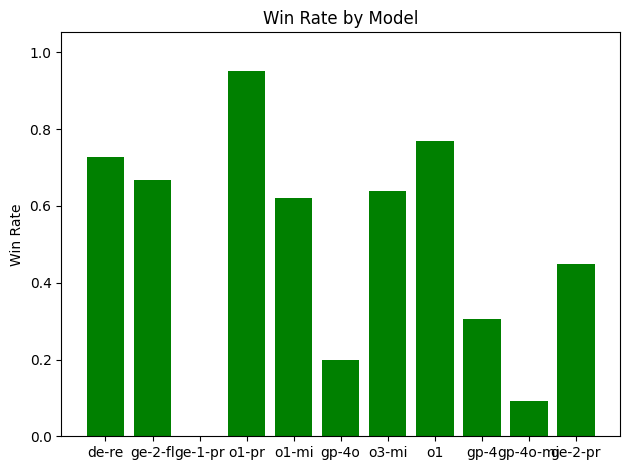

In [10]:
import matplotlib.pyplot as plt
import json

# Original data with wins ('w') and loses ('l')
raw_data = {
  "deepseek-reasoner": {
    "w": 16,
    "l": 6
  },
  "gemini-2.0-flash-exp": {
    "w": 0,
    "l": 4
  },
  "gemini-1.5-pro": {
    "w": 0,
    "l": 4
  },
  "o1-preview": {
    "w": 20,
    "l": 1
  },
  "o1-mini": {
    "w": 18,
    "l": 11
  },
  "gpt-4o": {
    "w": 5,
    "l": 20
  },
  "o3-mini": {
    "w": 16,
    "l": 9
  },
  "o1": {
    "w": 20,
    "l": 6
  },
  "gpt-4": {
    "w": 7,
    "l": 16
  },
  "gpt-4o-mini": {
    "w": 2,
    "l": 20
  },
  "gemini-2.0-flash-thinking-exp-01-21": {
    "w": 16,
    "l": 8
  },
  "gemini-2.0-pro-exp-02-05": {
    "w": 9,
    "l": 11
  }
}

# Transform the data by computing the win rate for each model.
result = {}
max_win_rate = 0  # Track the highest win rate to set y-axis

for model, counts in raw_data.items():
    win = counts.get("w", 0)
    lose = counts.get("l", 0)
    total = win + lose
    win_rate = win / total if total > 0 else 0
    result[model] = {
        "guesses": {"WIN": win, "LOSE": lose, "DROPPED": 0},
        "win_rate": win_rate
    }
    max_win_rate = max(max_win_rate, win_rate)  # Update max win rate

models = list(result.keys())

# Create a bar chart showing the win rate for each model.
fig, ax = plt.subplots()
stats = {}
plt.tight_layout()

for model in models:
    truncated_name = ("-".join([x[:2] for x in model.split("-")[:3]])).replace(".", "")
    win_rate = result[model]["win_rate"]
    stats[model] = {"win_rate": win_rate}
    ax.bar(truncated_name, win_rate, color='green')

ax.set_ylabel('Win Rate')
ax.set_title('Win Rate by Model')
plt.tight_layout()
# Set y-axis limit slightly above max win rate for better visibility
ax.set_ylim(0, max_win_rate + 0.1)

plt.show()


deepseek-reasoner
gemini-2.0-flash-thinking-exp-01-21
gemini-2.0-pro-exp-02-05
o1-preview
o1-mini
gpt-4o
o3-mini
o1
gpt-4
gpt-4o-mini


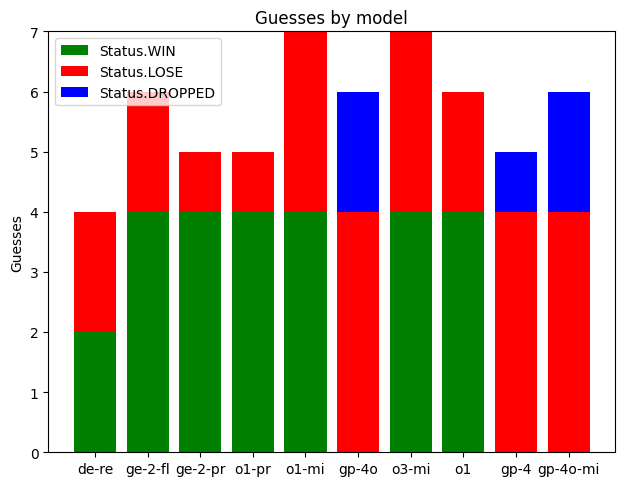

#### `{"deepseek-reasoner": {"w": 2, "l": 2}, "gemini-2.0-flash-thinking-exp-01-21": {"w": 4, "l": 2}, "gemini-2.0-pro-exp-02-05": {"w": 4, "l": 1}, "o1-preview": {"w": 4, "l": 1}, "o1-mini": {"w": 4, "l": 3}, "gpt-4o": {"w": 0, "l": 4}, "o3-mini": {"w": 4, "l": 3}, "o1": {"w": 4, "l": 2}, "gpt-4": {"w": 0, "l": 4}, "gpt-4o-mini": {"w": 0, "l": 4}}`


In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
stats = {}
truncation_length = 4
plt.tight_layout()

for model in models:
    print(model)
    truncated_name = ("-".join([x[:2] for x in model.split("-")[:3]])).replace(".", "")
    win = result[model]["guesses"][Status.WIN]
    lose = result[model]["guesses"][Status.LOSE]
    dropped = result[model]["guesses"][Status.DROPPED]
    stats[model] = {
        "w": win,
        "l": lose
    }
    ax.bar(truncated_name, win, color='g')
    ax.bar(truncated_name, lose, bottom=win, color='r')
    ax.bar(truncated_name, dropped, bottom=win+lose, color='b')

ax.set_ylabel('Guesses')
ax.set_title('Guesses by model')
ax.legend([Status.WIN, Status.LOSE, Status.DROPPED])
plt.show()
print(f"#### `{json.dumps(stats)}`")
